# Machine Learning Example

#### This notebook performs the mcahine learning codes to demonstrate the batteries classification problem.

In [1]:
# import needed packages
import sys
sys.path.append("../data-science-appraoches-for-tdcp-analysis")
import chachifuncs as ccf
import descriptors as d
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
# looks for any files that have been processed with the describe function 

k_list = [f for f in glob.glob('data/K_descriptors/*.xlsx')]
c_list = [f for f in glob.glob('data/C_descriptors/*.xlsx')]

In [3]:
# transform list to dataframe
c_data = pd.DataFrame()
for each in c_list:
    df = pd.read_excel(each)
    c_data = c_data.append(df,ignore_index=True)
c_data.shape

(390, 41)

In [4]:
# transform list to dataframe
k_data = pd.DataFrame()
for each in k_list:
    df = pd.read_excel(each)
    k_data = k_data.append(df,ignore_index=True)
k_data.shape

(640, 41)

In [5]:
# combine all data and drop any duplicate columns 
data = c_data.append(k_data)
df = data
data = data.T.drop_duplicates().T
data.columns

Index(['Unnamed: 0', 'ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6',
       'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14',
       'ch_15', 'ch_16', 'names', 'dc_0', 'dc_1', 'dc_2', 'dc_3', 'dc_4',
       'dc_5', 'dc_6', 'dc_7', 'dc_8', 'dc_9', 'dc_10', 'dc_11', 'dc_12',
       'dc_13', 'dc_14', 'dc_15'],
      dtype='object')

In [6]:
# create index
df.columns = ['Unnamed: 0', 'charge_poly_B0','charge_poly_B1','charge_poly_B2','charge_poly_B3','Charge_P1_loc','Charge_P1_height','Charge_P1_width',
              'Charge_P2_loc','Charge_P2_height','Charge_P2_width','Charge_P3_loc','Charge_P3_height','Charge_P3_width',
              'Charge_P4_loc','Charge_P4_height','Charge_P4_width','Charge_P5_loc','Charge_P5_height','Charge_P5_width',
              'names','discharge_poly_B0','discharge_poly_B1','discharge_poly_B2','discharge_poly_B3','Discarge_P1_loc','Disharge_P1_height','Discharge_P1_width','Discarge_P2_loc','Disharge_P2_height',
              'Discharge_P2_width','Discarge_P3_loc','Disharge_P3_height','Discharge_P3_width','Discarge_P4_loc',
              'Disharge_P4_height','Discharge_P4_width','Discarge_P5_loc','Disharge_P5_height','Discharge_P5_width','names']
df = df.T.drop_duplicates().T
df.columns

Index(['Unnamed: 0', 'charge_poly_B0', 'charge_poly_B1', 'charge_poly_B2',
       'charge_poly_B3', 'Charge_P1_loc', 'Charge_P1_height',
       'Charge_P1_width', 'Charge_P2_loc', 'Charge_P2_height',
       'Charge_P2_width', 'Charge_P3_loc', 'Charge_P3_height',
       'Charge_P3_width', 'Charge_P4_loc', 'Charge_P4_height',
       'Charge_P4_width', 'Charge_P5_loc', 'names', 'discharge_poly_B0',
       'discharge_poly_B1', 'discharge_poly_B2', 'discharge_poly_B3',
       'Discarge_P1_loc', 'Disharge_P1_height', 'Discharge_P1_width',
       'Discarge_P2_loc', 'Disharge_P2_height', 'Discharge_P2_width',
       'Discarge_P3_loc', 'Disharge_P3_height', 'Discharge_P3_width',
       'Discarge_P4_loc', 'Disharge_P4_height', 'Discharge_P4_width'],
      dtype='object')

In [7]:
#reset index
data = data.reset_index(drop = True)

for i in range(len(data)):
    if data.loc[i, ('names')].startswith('CS2_33'):
        data.loc[i, ('label')] = 'LiCoO2'
        data.loc[i, ('lasso')] = 0
    else:
        data.loc[i,('label')] = 'LiFePO4'
        data.loc[i, ('lasso')] = 1

data.label.unique()

array(['LiCoO2', 'LiFePO4'], dtype=object)

In [8]:
# check the shape of the dataset
print ("Shape of dataset: ",data.shape) #size of dataset
data.head(10) 

Shape of dataset:  (1030, 37)


,Unnamed: 0,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,ch_8,...,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,label,lasso
0,0,265277,-268726,101982,-17184.3,3.82003,2.16721,0.0217102,3.92112,4.23149,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
1,1,43254.7,-44274.2,16952.6,-2878,3.81258,1.90613,0.0139044,3.91042,4.2129,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
2,2,45929.8,-46833.5,17864.9,-3021.49,3.8155,1.83571,0.0149,3.91593,4.39144,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
3,3,79724.4,-82505,31956.2,-5490.66,3.80724,1.93758,0.00814911,3.85227,1.46473,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
4,4,39853.3,-40890.7,15694.2,-2670.63,3.80464,1.95089,0.0146962,3.90313,3.84962,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
5,5,61522.7,-63039.9,24174.7,-4112.24,3.81534,1.79809,0.0133558,3.91026,4.32505,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
6,6,56114.3,-57457.8,22016,-3741.5,3.81404,1.7871,0.0143419,3.91269,4.08066,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
7,7,85686.3,-88035.4,33859.3,-5777.95,3.81534,1.71727,0.000296707,3.91512,4.33631,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
8,8,52871.6,-54283.8,20856.3,-3554.04,3.8095,1.7962,0.112926,3.90799,4.20811,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
9,9,80334.4,-82886.1,32010.3,-5484.4,3.80805,1.85822,0.377574,3.90265,4.49684,...,0,0,0,0,0,0,0,0,LiCoO2,0.0


In [9]:
print("The following features were found: ") #column names 
data.columns

The following features were found: 


Index(['Unnamed: 0', 'ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6',
       'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14',
       'ch_15', 'ch_16', 'names', 'dc_0', 'dc_1', 'dc_2', 'dc_3', 'dc_4',
       'dc_5', 'dc_6', 'dc_7', 'dc_8', 'dc_9', 'dc_10', 'dc_11', 'dc_12',
       'dc_13', 'dc_14', 'dc_15', 'label', 'lasso'],
      dtype='object')

In [10]:
unique = data['label'].unique()
print ("There are", len(unique), "unique batteries in this dataset: ", unique) #how many unique batteries are we looking at

There are 2 unique batteries in this dataset:  ['LiCoO2' 'LiFePO4']


In [11]:
# split up data into test train set 80/20
train,test = train_test_split(data, test_size=0.2, random_state=1010)
print (train.shape, test.shape)

(824, 37) (206, 37)


In [12]:
# LASSO 
# feature selection
train_lasso_y = train['lasso']
train_lasso_x = train[['ch_4','ch_5','ch_7','ch_8','ch_10','ch_11','dc_4','dc_5','dc_7','dc_10','dc_11']] # all the descriptors
test_lasso_y = test['lasso']
test_lasso_x = test[['ch_4','ch_5','ch_7','ch_8','ch_10','ch_11','dc_4','dc_5','dc_7','dc_10','dc_11']]
# 4,5,7,8,10,11

train_lasso_x_scaled  = preprocessing.normalize(train_lasso_x, norm='l1')
test_lasso_x_scaled  = preprocessing.normalize(test_lasso_x, norm='l1')

In [13]:
clf = linear_model.Lasso(alpha=0.004, tol=0.0001 ,max_iter=5000)
clf.fit(train_lasso_x_scaled,train_lasso_y)
coef = clf.coef_

coef

#ch_5,ch_7,ch_5 are the important descriptors

array([-0.        ,  1.61402366, -0.21140979, -0.        , -0.        ,
       -0.        , -0.        ,  1.61051302, -0.        ,  0.        ,
        0.        ])

In [14]:
train_y = train['lasso'] # what are we predicting 
test_y = test['lasso']

train_x = train[['ch_5','ch_7','dc_5']] # from LASSO 
test_x = test[['ch_5','ch_7','dc_5']]

train_x_scaled  = preprocessing.normalize(train_x, norm='l1')
test_x_scaled  = preprocessing.normalize(test_x, norm='l1')

# print (train_y.shape, train_x.shape) #check y should by (datapoints,), x should by (datapoints,descriptors)

print ("Data points in train/test: ",train_x.shape[0],"/", test_x.shape[0])

Data points in train/test:  824 / 206


In [15]:
#Support Vector Machine 
#-->Chosen under the assumption that eventually more batteries will be added with highly dimensional features that 
# can not be seperated by simple linear or logistic regression models 

lin_svc = svm.LinearSVC().fit(train_x, train_y)
trainpred=lin_svc.predict(train_x_scaled) #predict train data 
testpred=lin_svc.predict(test_x_scaled)

C:\Users\pouy5\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Accuracy

In [16]:
# define a function that calculates the accuracy of the classification
def accuracy(test_df,pred_df):
    """Calculates the amount of data classified correctly"""
    #Input for test_y should be the test dataframe (ex -- see below)
    N= len(pred_df)
    compare = np.array([test_df.lasso, pred_df]).reshape(N,2)
    asses = pd.DataFrame (compare, columns = ['actual','predicted'])
    count = 0
    correct = 0
    for i in range(len(compare)):
        if asses.loc[i,('actual')] == asses.loc[i, ('predicted')]:
            correct += 1 
            count += 1 
            asses.loc[i, ('correct')] = 1
        else: 
            count += 1
            asses.loc[i, ('correct')] = 0
    #print (correct)
    return (1-correct/count)*100, asses

In [17]:
# determine the accuracy of the training and testing set
test_error, test_df,  = accuracy(test,testpred)
train_error, train_df,  = accuracy(train,trainpred)
print ("Testing error: ","%.2f" %test_error,"%")
print ("Training error: ","%.2f" %train_error,"%")

Testing error:  20.39 %
Training error:  24.03 %


In [18]:
# show 5 of the training set
pd_train_y = pd.DataFrame(train['label'])
frames = [train_x,pd_train_y]
datatot = pd.concat(frames, axis=1, ignore_index = True)
datatot.columns = 'ch_5', 'ch_7','dc_5', 'Label'
datatot.head()

,ch_5,ch_7,dc_5,Label
209,1.63352,3.89698,3.6107,LiCoO2
687,10.0183,0,12.2803,LiFePO4
658,9.9498,0,11.8771,LiFePO4
768,10.3166,0,11.8076,LiFePO4
809,10.8254,0,12.281,LiFePO4


In [24]:
# show 5 of the testing set
plt.rcParams.update({'font.size':12})

colors = ['red', 'blue']
datatot = datatot.reset_index(drop = True)
for i in range(len(datatot)):
    if datatot.loc[i, ('Label')] == 'LiCoO2':
        datatot.loc[i, ('Color')] = 'R'
    elif datatot.loc[i, ('Label')] == 'LiFePO4':
        datatot.loc[i, ('Color')] = 'B'
    else: 
        test_x.loc[i, ('Color')] = 'G'
#plt.scatter([datatot['ch_7'], datatot['dc_5'], datatot['ch_5'], c = datatot['Color'])
datatot.head()

,ch_5,ch_7,dc_5,Label,Color
0,1.63352,3.89698,3.6107,LiCoO2,R
1,10.0183,0,12.2803,LiFePO4,B
2,9.9498,0,11.8771,LiFePO4,B
3,10.3166,0,11.8076,LiFePO4,B
4,10.8254,0,12.281,LiFePO4,B


In [20]:
plt.rcParams.update({'font.size':12})

colors = ['red', 'blue']
test_df = test_df.reset_index(drop = True)
test_x = test_x.reset_index(drop = True)
for i in range(len(test_df)):
    if test_df.loc[i, ('correct')] == 0:
        test_x.loc[i, ('Predicted Col')] = 'G'
    elif (test_df.loc[i, ('correct')] == 1) and (test_df.loc[i, ('actual')] == 1) :
        test_x.loc[i, ('Predicted Col')] = 'B'
    elif (test_df.loc[i, ('correct')] == 1) and (test_df.loc[i, ('actual')] == 0) :
        test_x.loc[i, ('Predicted Col')] = 'R'
    else:
        test_x.loc[i, ('Predicted Col')] = 'G'        
test_x.head()

,ch_5,ch_7,dc_5,Predicted Col
0,9.97241,0,11.6374,B
1,11.0311,0,12.2452,B
2,10.2378,0,12.2238,G
3,9.84954,0,11.3034,G
4,10.6847,0,12.3985,G


C:\Users\pouy5\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  """
C:\Users\pouy5\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  


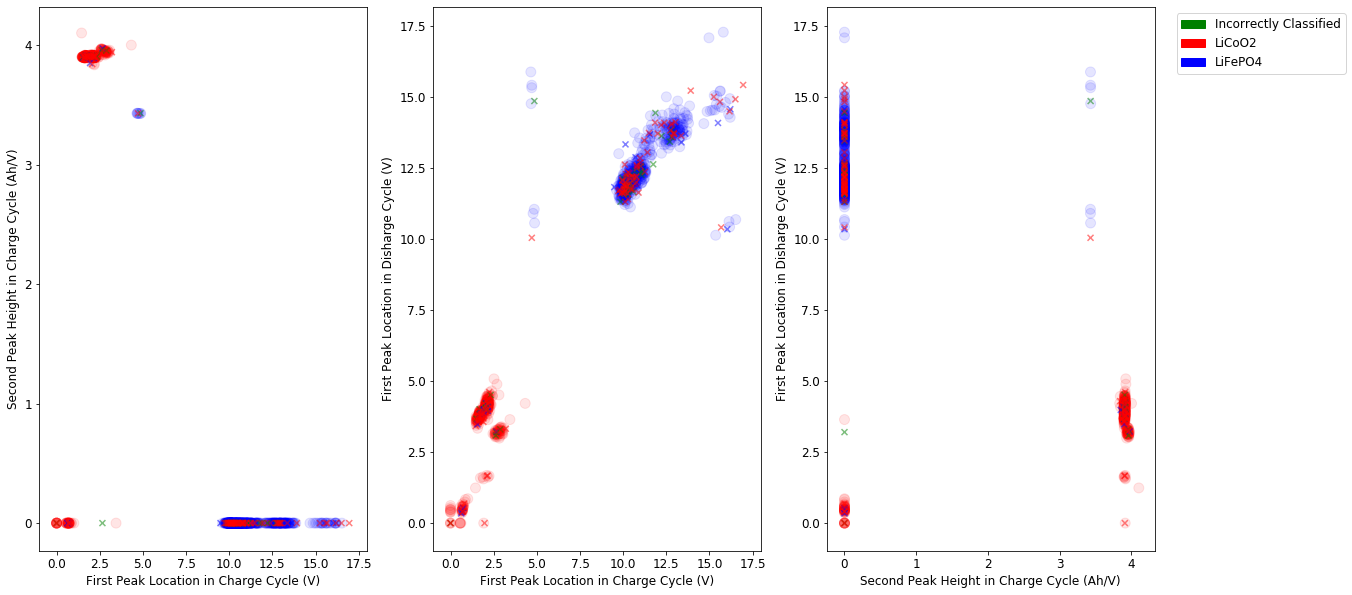

In [21]:
#x's are test data
#circles are training data

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.scatter(datatot['ch_5'], datatot['ch_7'], c = datatot['Color'], alpha=0.1, s=100)
ax1.scatter(test_x['ch_5'], test_x['ch_7'], c = test_x['Predicted Col'], alpha=0.5, marker = "x")
ax1.set_xlabel('First Peak Location in Charge Cycle (V)')
ax1.set_ylabel('Second Peak Height in Charge Cycle (Ah/V)')
ax2.scatter(datatot['ch_5'], datatot['dc_5'], c = datatot['Color'], alpha=0.1, s=100)
ax2.scatter(test_x['ch_5'], test_x['dc_5'], c = test_x['Predicted Col'], alpha=0.5, marker = "x")
ax2.set_xlabel('First Peak Location in Charge Cycle (V)')
ax2.set_ylabel('First Peak Location in Disharge Cycle (V)')
ax3.scatter(datatot['ch_7'], datatot['dc_5'], c = datatot['Color'], alpha=0.1, s=100)
ax3.scatter(test_x['ch_7'], test_x['dc_5'], c = test_x['Predicted Col'], marker = "x", alpha = 0.5)
ax3.set_xlabel('Second Peak Height in Charge Cycle (Ah/V)')
ax3.set_ylabel('First Peak Location in Disharge Cycle (V)')

legend_dict = { 'Incorrectly Classified' : 'green', 'LiCoO2' : 'red', 'LiFePO4' : 'blue' }
patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)

plt.legend(handles=patchList,loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.savefig('legend.png', bbox_inches='tight')

plt.show()